# Mod6L5 Data Challenge — Interpreting SLR Output (Dec 2023 NYC Taxi)


**Format:** We Do (Instructor prompts) → You Do (Student work) → We Share (reflection)


**Goal:** Choose **one** dependent variable (**Y**) from the taxi dataset and build **three** simple linear regressions (each with a different single **X**) on **Dec 2023** rides. For each model, interpret the **coefficient**, **intercept**, **p‑value**, and **R‑squared** in plain business language. Then decide which model is “better” *for decision‑making* and why.


> **Reminder:** No train/test split or advanced metrics today. We focus on reading `.summary()` and communicating results.

## Instructor Section (10 mins)

**Follow these steps/considerations as you work**


1) **Pick a useful Y.** Which outcome would someone actually act on?  Who is the stakeholder for your Y?

*Avoid constructing Y that bakes in your X (e.g., avoid using `fare_amount` as X when Y = `total_amount` which already includes fare).*


2) **Choose three X’s** you can know at decision time, and that plausibly relate to Y. 

*You may engineer a feature to use in the model if you like*

*Note:  SLR needs numeric only inputs so variables like `PULocationID` can't be used (categorical → not for SLR today unless you transform; stick to numeric X for this exercise)*


3) **Interpretation lenses:**
- **Units:** Always state slope in units (e.g., “per mile”, “per minute”).
- **p‑value:** Does evidence suggest the slope ≠ 0?
- **R²:** How much of Y’s variation is captured by this X? Does that help the decision?
- **Intercept:** Is X=0 meaningful? If not, say it’s a math anchor.
- **Plausibility:** Does the direction/size make sense (e.g., longer trip → higher fare)?


4) **Better ≠ only higher R².** Weigh **interpretability**, **actionability**, and **evidence** (p‑value, CI) alongside R².

## YOU DO (40 mins)

### Step 1: Read in the Data & Choose your **Y** (dependent variable)

Pick one from the 2023_Yellow_Taxi_Trip_Data_20251015 csv file  

**Ro: Perchance, Tip amt**

### Step 2: Propose three candidate **X** predictors (numeric)

Pick three different X columns that are **numeric** and **known at decision time**.

**Ro:**

- passenger_count
- pickup time
- payment_type

### Step 3: Fit three one‑variable models with the SAME Y and different Xs

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv'

df = pd.read_csv(path, low_memory=False)

In [3]:
df['passenger_count'].unique()

array([ 2.,  3.,  1.,  6.,  0., nan,  5.,  4.,  8.,  9.,  7.])

In [4]:
# converting tip_amount to float
df['tip_amount'] = pd.to_numeric(df['tip_amount'].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True), errors='coerce')

# converting passenger count
df['passenger_count'] = pd.to_numeric(df['passenger_count'].astype(str).str.strip().replace(to_replace='nan', value=0, regex=True), errors='coerce')
df['passenger_count'] = df['passenger_count'].astype(int)

# pickup hour
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

df.dtypes

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_90606/2656231753.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])


VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime            object
passenger_count                   int64
trip_distance                    object
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                      object
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                     object
congestion_surcharge            float64
airport_fee                     float64
pickup_hour                       int32
dtype: object

In [5]:
df['payment_type'].value_counts()

payment_type
1    2524107
2     535356
0     177380
4      52224
3      21840
Name: count, dtype: int64

In [6]:
# filtering tip_amount
df = df[(df['tip_amount'] >= 0) & df['tip_amount']< 1000]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_hour
0,2,2023-12-01 16:11:39,12/01/2023 04:19:13 PM,2,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3.00,0.00,1.0,17.4,2.5,0.00,16
1,1,2023-12-01 16:11:39,12/01/2023 04:20:41 PM,3,1.1,1.0,N,236,263,2,10,5.0,0.5,0.00,0.00,1.0,16.5,2.5,0.00,16
2,2,2023-12-01 16:11:39,12/01/2023 04:20:38 PM,1,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0.00,0.00,-1.0,-17.2,-2.5,0.00,16
3,2,2023-12-01 16:11:39,12/01/2023 04:20:38 PM,1,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0.00,0.00,1.0,17.2,2.5,0.00,16
4,1,2023-12-01 16:11:39,12/01/2023 04:34:39 PM,2,3,1.0,N,164,211,1,21.9,5.0,0.5,3.00,0.00,1.0,31.4,2.5,0.00,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3310902,2,2024-01-01 00:01:58,01/01/2024 12:10:04 AM,3,1.7,1.0,N,234,144,1,10.7,1.0,0.5,2.36,0.00,1.0,18.06,2.5,0.00,0
3310903,2,2024-01-03 10:00:04,01/03/2024 11:08:22 AM,1,21.6,1.0,N,132,136,1,82.1,0.0,0.5,18.46,6.94,1.0,110.75,0.0,1.75,10
3310904,2,2024-01-03 17:00:52,01/03/2024 05:01:05 PM,2,0,5.0,N,265,265,1,120,0.0,0.0,0.00,0.00,1.0,121,0.0,0.00,17
3310905,2,2024-01-03 18:43:26,01/03/2024 06:43:29 PM,2,0.01,5.0,N,95,95,1,86.69,0.0,0.0,17.54,0.00,1.0,105.23,0.0,0.00,18


In [7]:
# Model 1: passenger_count
X1 = sm.add_constant(df[['passenger_count']]) #add intercept yourself for statsmodels
y1 = df['tip_amount']
model = sm.OLS(y1, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6949.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:58:09   Log-Likelihood:            -9.8314e+06
No. Observations:             3310907   AIC:                         1.966e+07
Df Residuals:                 3310905   BIC:                         1.966e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               3.2077      0.004    714.280      0.000       3.199       3.217
passenger_count     0.2292      0.003     83.360      0.000       0.224       0.235
================================================================================
Omnibus:                 16506373.102   Durbin-Watson:                     1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   4731827832217859.000
Skew:                         212.079   Prob(JB):                           0.00
Kurtosis:                  185204.909   Cond. No.                           3.62
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# Model 2: pickup_hour
X1 = sm.add_constant(df[['pickup_hour']]) #add intercept yourself for statsmodels
y1 = df['tip_amount']
model = sm.OLS(y1, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1967.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:58:09   Log-Likelihood:            -9.8339e+06
No. Observations:             3310907   AIC:                         1.967e+07
Df Residuals:                 3310905   BIC:                         1.967e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.2333      0.007    473.340      0.000       3.220       3.247
pickup_hour     0.0195      0.000     44.348      0.000       0.019       0.020
================================================================================
Omnibus:                 16495669.949   Durbin-Watson:                     1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   4702011533586844.000
Skew:                         211.590   Prob(JB):                           0.00
Kurtosis:                  184620.487   Cond. No.                           41.0
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
# Model 3: payment_type
X1 = sm.add_constant(df[['payment_type']]) #add intercept yourself for statsmodels
y1 = df['tip_amount']
model = sm.OLS(y1, X1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                 2.055e+05
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        15:58:10   Log-Likelihood:            -9.7352e+06
No. Observations:             3310907   AIC:                         1.947e+07
Df Residuals:                 3310905   BIC:                         1.947e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.7501      0.006   1038.162      0.000       5.739       5.761
payment_type    -1.9138      0.004   -453.284      0.000      -1.922      -1.906
================================================================================
Omnibus:                 16921665.953   Durbin-Watson:                     1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   6006765268889330.000
Skew:                         231.802   Prob(JB):                           0.00
Kurtosis:                  208668.855   Cond. No.                           4.33
================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div align='center'>

### **Notes**

P-value tells us that there is a statistically significant effect, but the R-squared tells us that the effect size is not that big.

</div>

### Step 4: Visual check for the “best” model candidate

Pick the model you currently prefer (based on business sense + evidence).
- Create a scatter of X vs. Y with the fitted line.

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_90606/2863499019.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x=df['passenger_count'], y=df['tip_amount'], color='red', ci=None)


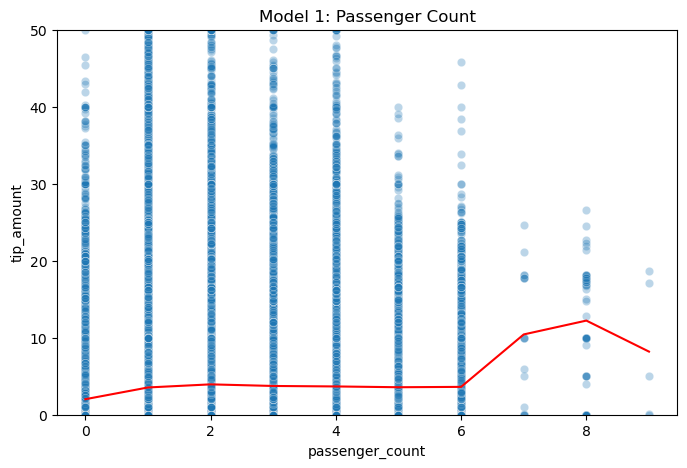

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['passenger_count'], y=df['tip_amount'], alpha=0.3)
sns.lineplot(data=df, x=df['passenger_count'], y=df['tip_amount'], color='red', ci=None)
plt.ylim((0,50))
plt.title('Model 1: Passenger Count')
plt.show()

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_90606/1725941998.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x=df['pickup_hour'], y=df['tip_amount'], color='red', ci=None)


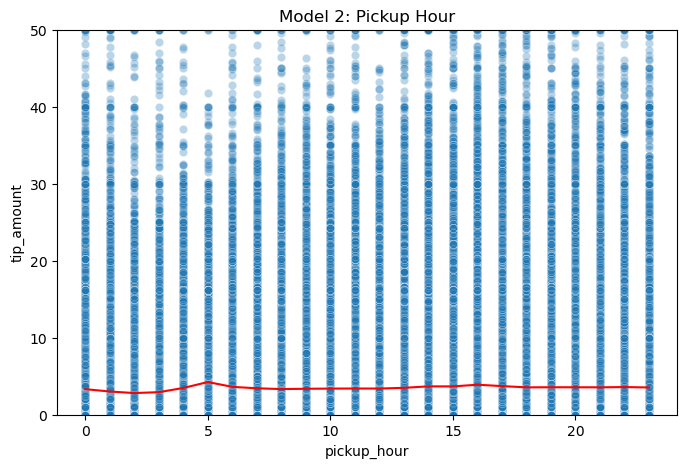

In [11]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['pickup_hour'], y=df['tip_amount'], alpha=0.3)
sns.lineplot(data=df, x=df['pickup_hour'], y=df['tip_amount'], color='red', ci=None)
plt.ylim((0,50))
plt.title('Model 2: Pickup Hour')
plt.show()

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_90606/3023023380.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x=df['payment_type'], y=df['tip_amount'], color='red', ci=None)


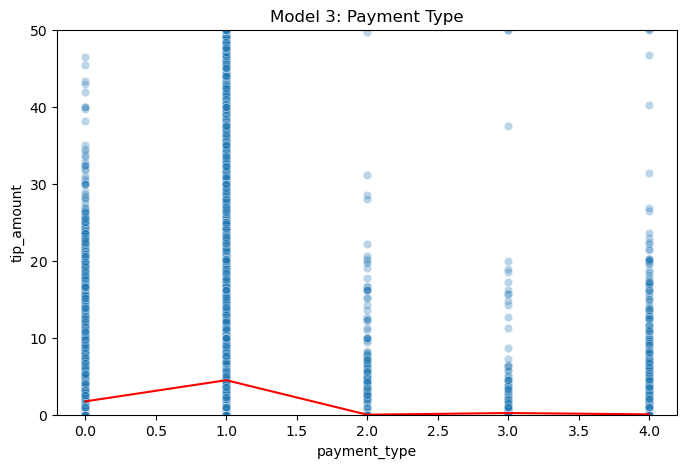

In [13]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x=df['payment_type'], y=df['tip_amount'], alpha=0.3)
sns.lineplot(data=df, x=df['payment_type'], y=df['tip_amount'], color='red', ci=None)
plt.ylim((0,50))
plt.title('Model 3: Payment Type')
plt.show()

### Step 5: Interpret Each Model (write in plain English)
Fill the three blocks below. Use **units** and **percentage points (pp)** where relevant.

- **Slope (β₁):** “For each +1 unit of X, Y changes by …”
- **Intercept (β₀):** meaningful or just a math anchor? Explain.
- **p‑value:** is there evidence the slope ≠ 0?
- **R²:** how much variation does this X explain?
- **Judgment:** is the effect size **practically** meaningful (tie to business)?

### Model A — Y = {{tip_amount}} ~ X1 = {{passenger_count}}
- Slope (β₁): for each +1 unit of passenger_count, tip_amount increases by $0.23.

- Intercept (β₀): at 0 passenger_count, tip_amount is $3.21. This in negligible and only represents a math anchor, since you wouldn't have tip if you didn't have any passengers.

- p‑value (slope): Our p-value is very small, indiciating that there is statistical significance between passenger_count and tip_amount.

- 95% CI for slope: 0.224 - 0.235. This is the range we are 95% confident that our tip_amount increases for each +1 passenger.

- R²: The R-Squared is 0.002, very very small. This is not a good factor for the y.

- Business readout (units): This model tells us that for every passenger increase, the tip amount increases by $0.23. However, this is not a good indication for tip_amount as the model tells us the passenger count does not account for much variation of our tip amount.

- One limitation: It could be better to be able to filter our tip amount for more accuracy of its variation.

### Model B — Y = {{tip_amount}} ~ X2 = {{pickup_hour}}
- Slope (β₁): For each +1 unit of pickup_hour, tip_amount increased by $0.19. This may be slightly misleading, however, since pickup_hour represents a the 24hour range, and not some increasing value.
- Intercept (β₀): at 0 pickup_hour, the tip_amount would be $3.23. It's a bit hard to decipher, but this could be telling us that we are seeing $3.23 tips around the 0th hour of the day, which would be 12am in 12-hour time.
- p‑value (slope): Our p-value here is also very small, still telling us that there is a statistical significance between pickup_hour and tip_amount.
- 95% CI for slope: 0.019 - 0.020. This is our range for our slope. This is telling us that it's very precise, but it being very small could also signal issues with the data used for the model. (Maybe overfitting?)
- R²: Very small R-squared: 0.001. This is telling us that pickup_hour is not a significant factor for the variation of tip_amount at ALL.
- Business readout (units): Overall, this model is telling us that as the hours of the day go on, we're seeing an increase in tips by $0.19. This isn't a lot, and it also seems that pickup_hour isn't the best representation of what affects tips.
- One limitation: This data wasn't the best to use for a SLR. My guess would be that it is trying to fit a straight line onto data that will inherently be curved, since tips will likely be denser during certain hours over other ones.

### Model C — Y = {{tip_amount}} ~ X3 = {{payment_type}}
- Slope (β₁): For each +1 unit of payment_type, tip_amount decreases by $1.91.
- Intercept (β₀): at payment_type 0, our baseline tip_amount is $5.75. This could be a meaningful anchor, since payment_type of 0 is representative of a real payment_type that the model is accounting for. (Note: the data dictionary does not detail what payment type the numbers represent.)
- p‑value (slope): Our p-value is very low, telling us that there is a statistical significance between payment_type and tip_amount.
- 95% CI for slope: (-1.92) - (-1.91). This is the range we are 95% confident that the payment types are differing.
- R²: While higher than the others, our R-squared here is still very low, at 0.058. This is telling us that this still isn't a good indicator of the variation of tip_amount.
- Business readout (units): Essentially, as we increase the number representing payment types, we are seeing the tip_amount decrease. For example, if 0 = Cash, 1 = Debit, and 2 = Credit, the model would be telling us that Cash typically pays out $5.75 in tips, and decreases by $1.91 as we follow the proceeding payment types.
- One limitation: Again, this data may not be best use for a SLR. It's not the best indicator of the variation of tip_amount, and we also do not have information on what payment type the numbers represent.

## We Share (10 mins) — Reflection & Decision (write 1-2 short paragraphs)

1) **Which model is “better” for a stakeholder decision and why?**
- Weigh **evidence** (p‑value, CI), **explanatory power** (R²), **interpretability**, and **business impact** (units, MDE if relevant).
2) **What would you do next week to strengthen trust in this model?**
- (Preview) time‑based validation, hold‑out testing, segment checks, adding more plausible X’s, checking assumptions.

> [!NOTE]
> Since none of the models weren't well in representing our y, I'll try to explain Model 1 the best to answer the reflection.

Model 1, measuring passenger_count with the variation of tip_amount, was the better model for stakeholder decisions. Our variable is discrete and has a meaningful value of order, giving us the amount of passengers per ride. This is better than the other two models, which represented categories and thus made the models harder to decipher.

When inputting into our model, we found with 95% confidence that each additional passenger per ride accounts for an increased $0.22 - 0.24 in tips. 

Despite this, although our model results tell us that the number of passengers does statistically significantly affect tips, the number of passengers does not play a big role in the variation of tips drivers receive. 

Therefore, going forward, I would continue to test different variables to find which played a more significant role in the varying tip amounts. Or, I could even combine these variables to see if they made a bigger effect in conjunction with each other, rather than seperately.